In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import shutil

from torchvision import transforms, datasets
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchvision.utils import save_image
import shutil


from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [4]:
# Paths
csv_path = "/kaggle/input/chexpert/train.csv"
images_base_path = "/kaggle/input/chexpert/train"

PROJECT_ROOT = "/kaggle/working"
output_base_path = os.path.join(PROJECT_ROOT, "dataset")

# Dataset Processing

In [5]:
#Loading the csv file
df = pd.read_csv(csv_path)

df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [6]:
df = df.copy()

df["label"] = df["Lung Lesion"].apply(
    lambda x: 1 if x == 1.0 else 0
)

In [7]:
df["label"].value_counts()

label
0    214228
1      9186
Name: count, dtype: int64

In [8]:
df_pos = df[df["label"] == 1]
df_neg = df[df["label"] == 0]

print("Before balancing:")
print(df_pos.shape, df_neg.shape)

# Subsample negatives to match positives
df_neg_balanced = df_neg.sample(
    n=len(df_pos),
    random_state=42
)

# Combine and shuffle
df_balanced = pd.concat([df_pos, df_neg_balanced]).sample(
    frac=1,
    random_state=42
)

print("After balancing:")
print(df_balanced["label"].value_counts())


Before balancing:
(9186, 20) (214228, 20)
After balancing:
label
0    9186
1    9186
Name: count, dtype: int64


In [9]:
# Splitting into train, test, val
train_val_df, test_df = train_test_split(
    df_balanced, 
    test_size=0.2, 
    stratify=df_balanced["label"], 
    random_state=42
)

train_df, val_df = train_test_split(
    train_val_df, 
    test_size=0.2, 
    stratify=train_val_df["label"], 
    random_state=42
)

print("Train:", train_df["label"].value_counts())
print("Validation:", val_df["label"].value_counts())
print("Test:", test_df["label"].value_counts())


Train: label
1    5879
0    5878
Name: count, dtype: int64
Validation: label
1    1470
0    1470
Name: count, dtype: int64
Test: label
0    1838
1    1837
Name: count, dtype: int64


In [10]:
def copy_images(df, split_name):
    for idx, row in df.iterrows():
        label = str(row["label"])
        img_path = os.path.join(images_base_path, os.path.relpath(row["Path"], "CheXpert-v1.0-small/train"))
        out_dir = os.path.join(output_base_path, split_name, label)
        os.makedirs(out_dir, exist_ok=True)

        patient_folder = os.path.basename(os.path.dirname(os.path.dirname(img_path)))
        original_filename = os.path.basename(img_path)
        new_filename = f"{patient_folder}_{original_filename}"

        dest_path = os.path.join(out_dir, new_filename)
        shutil.copy(img_path, dest_path)

copy_images(train_df, "train")
copy_images(val_df, "val")
copy_images(test_df, "test")


In [11]:
# ImageNet normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_dataset = datasets.ImageFolder(os.path.join(output_base_path, "train"), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(output_base_path, "val"), transform=val_test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(output_base_path, "test"), transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Training CNN models

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [13]:
train_dataset = datasets.ImageFolder(
    root=os.path.join(output_base_path, "train"),
    transform=data_transforms['train']
)
val_dataset = datasets.ImageFolder(
    root=os.path.join(output_base_path, "val"),
    transform=data_transforms['val']
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [14]:
def get_alexnet():
    model = models.alexnet(pretrained=True)
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, 2)  # 2 classes: benign, malignant
    return model

def get_densenet():
    model = models.densenet121(pretrained=True)
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, 2)  # 2 classes: benign, malignant
    return model


In [15]:
SAVE_DIR = "/kaggle/working/models"
os.makedirs(SAVE_DIR, exist_ok=True)

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        val_loss, val_acc, all_labels, all_preds = evaluate_model(model, val_loader, criterion)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f'{SAVE_DIR}/{model.__class__.__name__}_best_weights.pth')

    return model

def evaluate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = running_corrects.double() / len(val_loader.dataset)

    return val_loss, val_acc, all_labels, all_preds


In [17]:
def compute_metrics(labels, preds):
    cm = confusion_matrix(labels, preds)
    recall = recall_score(labels, preds)
    precision = precision_score(labels, preds)
    f1 = f1_score(labels, preds)
    accuracy = accuracy_score(labels, preds)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(f'Recall: {recall:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Accuracy: {accuracy:.4f}')

    return cm, recall, precision, f1, accuracy


### Train AlexNet

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 229MB/s] 


Epoch 1/30, Train Loss: 0.5195, Train Acc: 0.5216, Val Loss: 0.7712, Val Acc: 0.5327
Epoch 2/30, Train Loss: 0.5013, Train Acc: 0.5269, Val Loss: 0.7916, Val Acc: 0.5381
Epoch 3/30, Train Loss: 0.4940, Train Acc: 0.5374, Val Loss: 0.7558, Val Acc: 0.5622
Epoch 4/30, Train Loss: 0.4875, Train Acc: 0.5482, Val Loss: 0.8788, Val Acc: 0.5164
Epoch 5/30, Train Loss: 0.4828, Train Acc: 0.5510, Val Loss: 0.8605, Val Acc: 0.4964
Epoch 6/30, Train Loss: 0.4779, Train Acc: 0.5511, Val Loss: 0.7218, Val Acc: 0.6038
Epoch 7/30, Train Loss: 0.4772, Train Acc: 0.5614, Val Loss: 0.8961, Val Acc: 0.5576
Epoch 8/30, Train Loss: 0.4696, Train Acc: 0.5665, Val Loss: 0.7300, Val Acc: 0.5633
Epoch 9/30, Train Loss: 0.4654, Train Acc: 0.5739, Val Loss: 0.7950, Val Acc: 0.5587
Epoch 10/30, Train Loss: 0.4587, Train Acc: 0.5800, Val Loss: 0.7392, Val Acc: 0.5629
Epoch 11/30, Train Loss: 0.4525, Train Acc: 0.5881, Val Loss: 0.7431, Val Acc: 0.5743
Epoch 12/30, Train Loss: 0.4444, Train Acc: 0.5968, Val Loss: 0

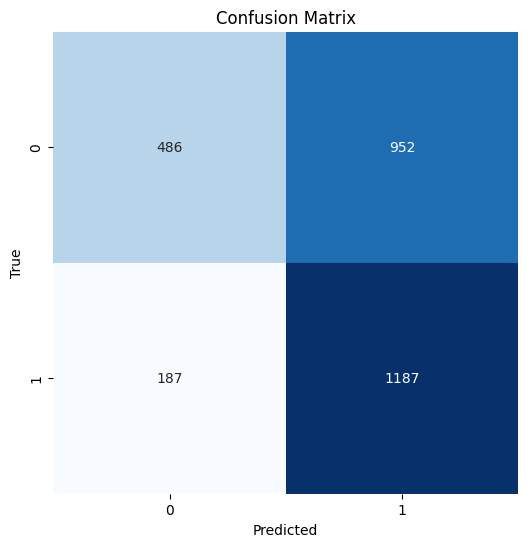

Recall: 0.8639
Precision: 0.5549
F1 Score: 0.6758
Accuracy: 0.5950


(array([[ 486,  952],
        [ 187, 1187]]),
 0.863901018922853,
 0.554932211313698,
 0.6757756902931967,
 0.594950213371266)

In [18]:

alexnet = get_alexnet().to(device)

for param in alexnet.features.parameters():
    param.requires_grad = False

class_weights = torch.tensor([1.0, 4.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, alexnet.parameters()),
    lr=1e-4
)

alexnet = train_model(
    alexnet,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=30
)


# Evaluate
_, _, labels, preds = evaluate_model(alexnet, val_loader, criterion)
compute_metrics(labels, preds)


### Train DenseNet

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 30.8M/30.8M [00:00<00:00, 147MB/s] 


Epoch 1/30, Train Loss: 0.6217, Train Acc: 0.5841, Val Loss: 0.6309, Val Acc: 0.6426
Epoch 2/30, Train Loss: 0.5948, Train Acc: 0.6159, Val Loss: 0.7426, Val Acc: 0.5932
Epoch 3/30, Train Loss: 0.5773, Train Acc: 0.6299, Val Loss: 0.6523, Val Acc: 0.6412
Epoch 4/30, Train Loss: 0.5644, Train Acc: 0.6479, Val Loss: 0.6565, Val Acc: 0.6234
Epoch 5/30, Train Loss: 0.5481, Train Acc: 0.6662, Val Loss: 0.7446, Val Acc: 0.6149
Epoch 6/30, Train Loss: 0.5371, Train Acc: 0.6727, Val Loss: 0.6552, Val Acc: 0.6583
Epoch 7/30, Train Loss: 0.5152, Train Acc: 0.6964, Val Loss: 0.6644, Val Acc: 0.6526
Epoch 8/30, Train Loss: 0.4912, Train Acc: 0.7163, Val Loss: 0.6963, Val Acc: 0.6426
Epoch 9/30, Train Loss: 0.4626, Train Acc: 0.7395, Val Loss: 0.6713, Val Acc: 0.6369
Epoch 10/30, Train Loss: 0.4311, Train Acc: 0.7624, Val Loss: 0.7430, Val Acc: 0.6277
Epoch 11/30, Train Loss: 0.3904, Train Acc: 0.7941, Val Loss: 0.9335, Val Acc: 0.6028
Epoch 12/30, Train Loss: 0.3597, Train Acc: 0.8167, Val Loss: 0

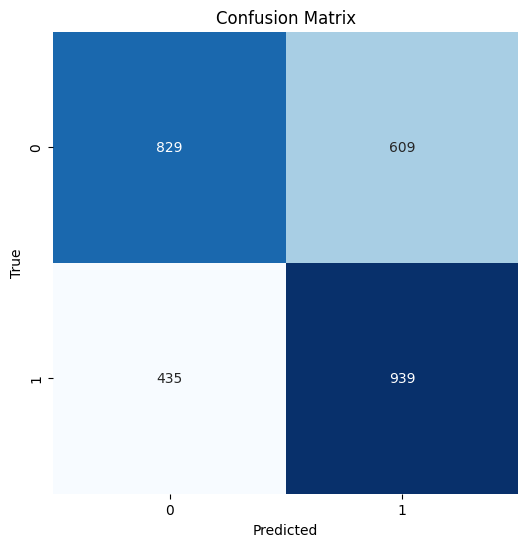

Recall: 0.6834
Precision: 0.6066
F1 Score: 0.6427
Accuracy: 0.6287


(array([[829, 609],
        [435, 939]]),
 0.6834061135371179,
 0.6065891472868217,
 0.6427104722792608,
 0.6287339971550497)

In [19]:
densenet = get_densenet().to(device)

class_weights = torch.tensor([1.0, 2.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(
    densenet.parameters(),
    lr=3e-4
)

densenet = train_model(
    densenet,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=30
)

# Evaluate
_, _, labels, preds = evaluate_model(densenet, val_loader, criterion)
compute_metrics(labels, preds)


In [20]:
torch.save(
    alexnet.state_dict(), 
    os.path.join(SAVE_DIR, "AlexNet_weights.pth"))


torch.save(
    densenet.state_dict(),
    os.path.join(SAVE_DIR, "DenseNet_weights.pth")
)